In [1]:
#%pip install redis
import pandas as pd
import redis
import os
os.environ['REDIS_HOST'] = 'localhost'
os.environ['REDIS_PASSWORD'] = ''
from plantd_modeling import configuration, metrics, build
# pip command for installying the python redis

import io
import matplotlib.pyplot as plt



2023-11-24 21:32:39 2023-11-24 21:53:09 0 days 00:20:30
1230.0


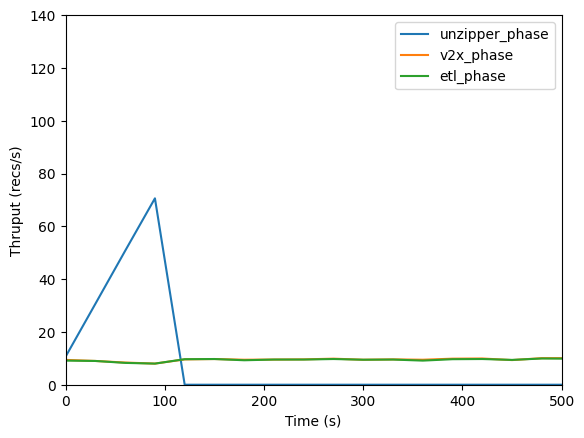

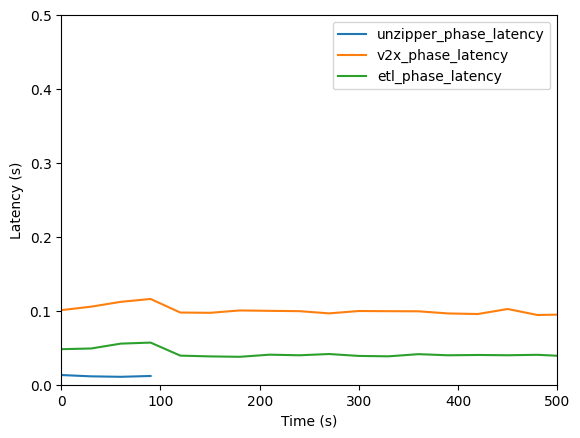

2023-11-23 19:22:07 2023-11-23 19:28:37 0 days 00:06:30
390.0
       unzipper_phase  v2x_phase  etl_phase
time                                       
0.0          0.000000   0.000000   0.000000
30.0        15.066667  36.066667  27.066667
60.0        54.866667  69.400000  64.200000
90.0        94.866667  65.266667  63.133333
120.0      134.902190  62.385412  64.518284
150.0       20.133333  74.866667  69.466667
180.0        0.000000  81.485613  72.416813
210.0        0.000000  78.276696  69.742794
240.0        0.000000  78.200000  70.066667
270.0        0.000000  76.728143  69.728543
300.0        0.000000  77.000000  73.066667
330.0        0.000000  73.948166  67.813232
360.0        0.000000  26.073620  68.542260
390.0        0.000000   0.000000  19.934662
22.845394492466603 319.83552289453246
57.12126073150453 799.6976502410633
57.1211848127324 799.6965873782536


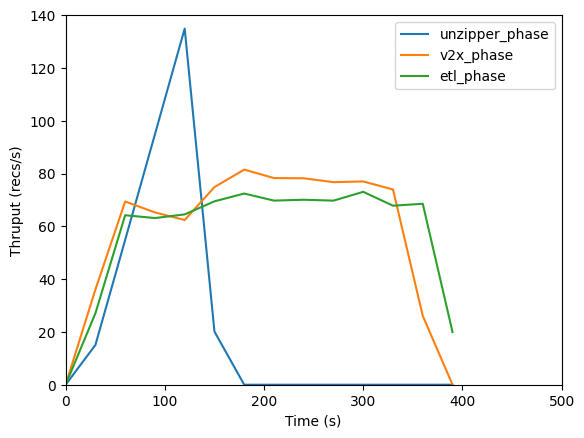

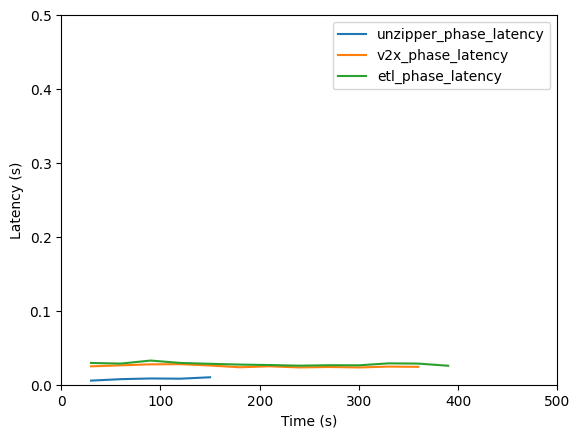

2023-11-24 20:29:11 2023-11-24 21:29:41 0 days 01:00:30
3630.0


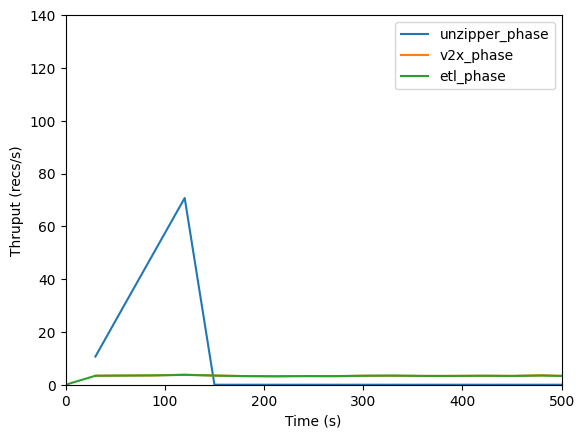

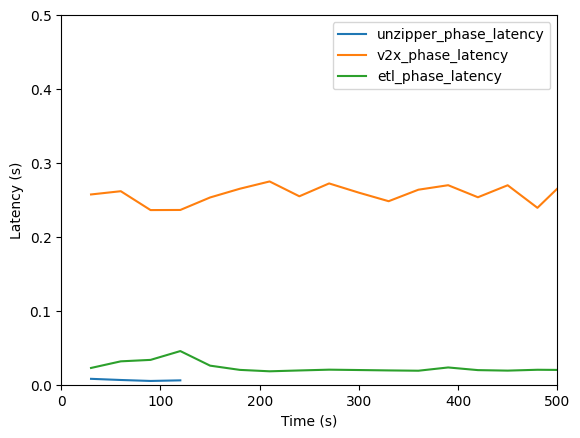

In [28]:
experiments = ["ubi-chris-test.ubi-chris-test-bad-triangle-3", "ubi-chris-test.ubi-chris-test-good-triangle-3", "ubi-chris-test.ubi-chris-test-fixed-triangle-3"]
rename = {"fixed": "cpu-limited", "bad": "blocking-write", "good": "non-blocking-write"}
for experiment in experiments:
    exp = metrics.redis.load_str("metrics", experiment)
    df = pd.read_csv(io.StringIO(exp))
    df["time"] = pd.to_datetime(df["time"])
    print(df["time"].min(), df["time"].max(), df["time"].max() - df["time"].min())
    span = df["time"].max() - df["time"].min()
    print(span.total_seconds())
    df["time"] = (df["time"] - df["time"].min()).dt.total_seconds()
    df.set_index("time", inplace=True)
    
    shortname = rename[experiment[len("ubi-chris-test.ubi-chris-test-"):-2].split("-")[0]]
    # set x and y axis limits
    plt.xlim(0, 500)#4800)
    plt.ylim(0, 140)

    if shortname == "non-blocking-write":
        print(df[["unzipper_phase","v2x_phase","etl_phase"]])
        print(df["unzipper_phase"].mean(), df["unzipper_phase"].sum())
        print(df["v2x_phase"].mean(), df["v2x_phase"].sum())
        print(df["etl_phase"].mean(), df["etl_phase"].sum())
       

    # set x and y axis labels
    plt.xlabel('Time (s)')
    plt.ylabel('Thruput (recs/s)')
    plt.plot(df[["unzipper_phase","v2x_phase","etl_phase"]])
    
    plt.legend(["unzipper_phase","v2x_phase","etl_phase"])
    #plt.title(shortname + " throughput")
    # save plot to file
    plt.savefig(shortname + "_throughput.png", bbox_inches='tight')
    plt.show()

    plt.xlim(0, 500)
    plt.ylim(0, 0.5)

    # set x and y axis labels
    plt.xlabel('Time (s)')
    plt.ylabel('Latency (s)')
    plt.plot(df[["unzipper_phase_latency","v2x_phase_latency","etl_phase_latency"]]/1000.0)
    
    plt.legend(["unzipper_phase_latency","v2x_phase_latency","etl_phase_latency"])
    #plt.title(shortname + " latency")
    plt.savefig(shortname + "_latency.png", bbox_inches='tight')
    plt.show()
    

In [3]:
import json
rows = []
cols = ["experiment",  "mean throughput", "mean latency", "median latency", "exp. length (s)", "total cost", "cost/hr"]
for experiment in experiments:
    raw_summary = metrics.redis.load_str("temp:experiment_summary", experiment)
    #print(raw_summary)
    exp_summary = json.loads(raw_summary)
    #print(type(exp_summary["mean_latency"]))
    shortname = rename[experiment[len("ubi-chris-test.ubi-chris-test-"):-2].split("-")[0]]
    rows.append({
        "experiment": shortname,
        "mean throughput": round(exp_summary["net_throughput"],2),
        "mean latency": round(exp_summary["mean_latency"],2),
        "median latency": round(exp_summary["mean_latency"],2),
        "exp. length (s)": round(exp_summary["total_span"],2),
        "total cost": round(exp_summary["total_cost"]*100.0,2),
        "cost/hr": round(exp_summary["cost_per_hour"]*100.0,2)
    })

experiment_summary = ("""
\\begin{table*}[]
\\begin{tabular}{llllllll}\n""")
experiment_summary += (" & ".join([c.replace("_", "\\_") for c in cols]))
experiment_summary += ("\\\\ \\hline\n")
for row in rows:
    experiment_summary += (" & ".join([str(row.get(k,"")) for k in cols]))
    experiment_summary += ("\\\\\n")
experiment_summary += ("\\hline\n")
experiment_summary += ("""\\end{tabular}
\\caption{Experiment results for three different pipeline variants.  Cost and cost per hour are in cents.}
\\label{tab:experiment-summary}
\\end{table*}
""")

print(experiment_summary)

with open("experiment_summary.tex", "w") as f:
    f.write(experiment_summary)



\begin{table*}[]
\begin{tabular}{llllllll}
experiment & mean throughput & mean latency & median latency & exp. length (s) & total cost & cost/hr\\ \hline
blocking-write & 1.95 & 0.15 & 0.15 & 1230.0 & 0.28 & 0.82\\
non-blocking-write & 6.15 & 0.06 & 0.06 & 390.0 & 0.76 & 7.03\\
cpu-limited & 0.66 & 0.29 & 0.29 & 3630.0 & 0.28 & 0.27\\
\hline
\end{tabular}
\caption{Experiment results for three different pipeline variants.  Cost and cost per hour are in cents.}
\label{tab:experiment-summary}
\end{table*}



wrote to simulation-lowplus-bad-wholeyear.png


<Figure size 800x200 with 0 Axes>

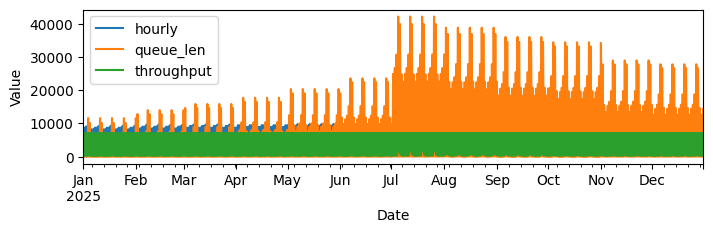

wrote to simulation-lowplus-bad-fewdays.png


<Figure size 800x200 with 0 Axes>

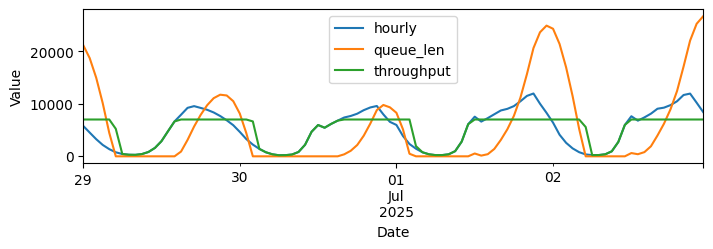

wrote to simulation-lowplus-good-wholeyear.png


<Figure size 800x200 with 0 Axes>

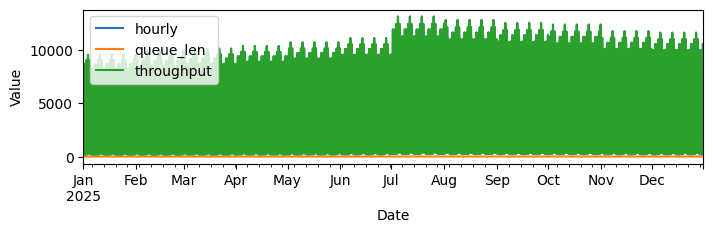

wrote to simulation-lowplus-good-fewdays.png


<Figure size 800x200 with 0 Axes>

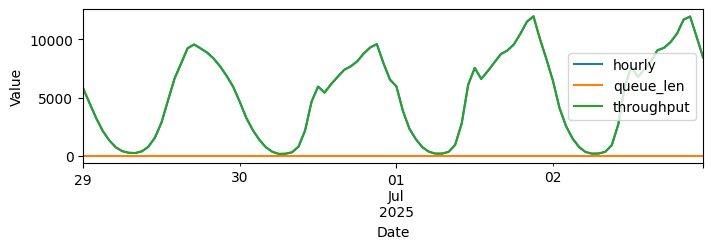

wrote to simulation-lowplus-fixed-wholeyear.png


<Figure size 800x200 with 0 Axes>

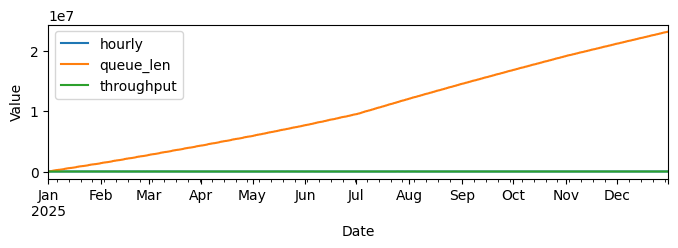

wrote to simulation-lowplus-fixed-fewdays.png


<Figure size 800x200 with 0 Axes>

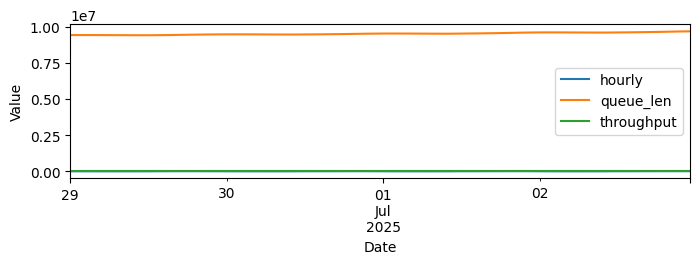

wrote to simulation-low-bad-wholeyear.png


<Figure size 800x200 with 0 Axes>

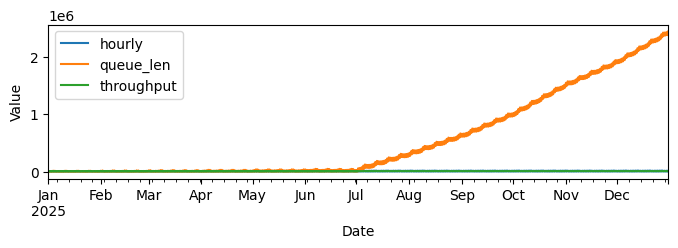

wrote to simulation-low-bad-fewdays.png


<Figure size 800x200 with 0 Axes>

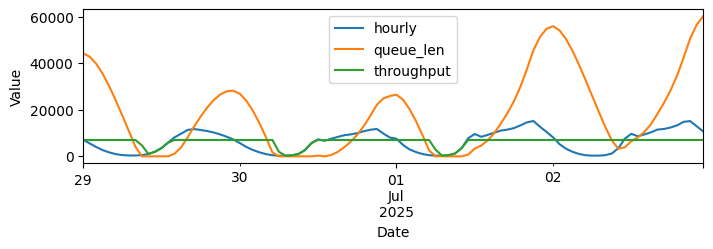

wrote to simulation-low-good-wholeyear.png


<Figure size 800x200 with 0 Axes>

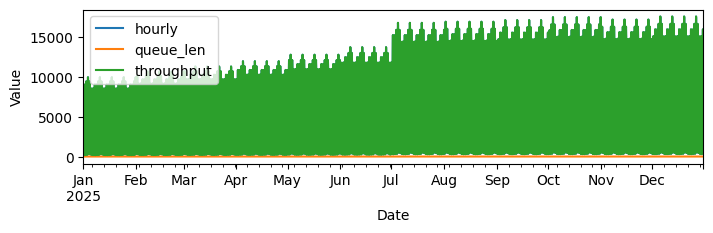

wrote to simulation-low-good-fewdays.png


<Figure size 800x200 with 0 Axes>

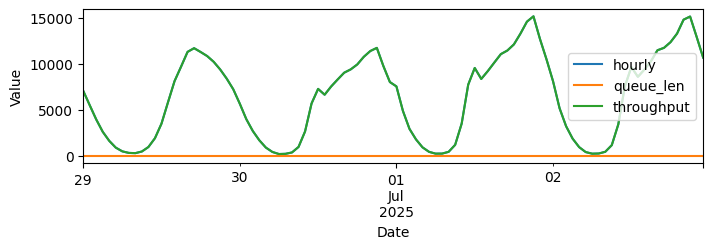

wrote to simulation-low-fixed-wholeyear.png


<Figure size 800x200 with 0 Axes>

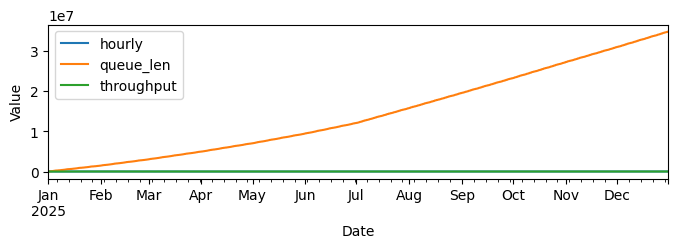

wrote to simulation-low-fixed-fewdays.png


<Figure size 800x200 with 0 Axes>

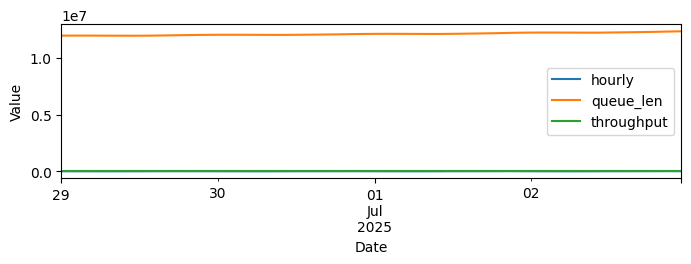

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from plantd_modeling import metrics
runs = [ "lowplus-bad", "lowplus-good", "lowplus-fixed", "low-bad", "low-good", "low-fixed"]#, "nom-bad", "nom-good", "nom-fixed"]

for run in runs:
    # Load the CSV file into a pandas DataFrame
    #df = pd.read_csv(f"oldfakeredis/simulation_test-{run}-tri.csv")
    raw = metrics.redis.load_str("simulation_traffic", f"test-{run}-tri")
    #print(run, raw)
    df = pd.read_csv(io.StringIO(raw), index_col=0, parse_dates=True)

    #print(df.head())
    #pri#nt(df)
    # Convert the "date" column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set the "date" column as the index
    df.set_index("date", inplace=True)


    plt.figure(figsize=(8, 2))

    # Plot the columns "cost", "scaleout", "hourly", "queue_len", "latency_fifo", "throughput", "scaleout" by date
    #df[["latency_fifo" ]].plot()  #, "throughput""hourly",
    theplot = df[["hourly", "queue_len", "throughput"]].plot()
    theplot.figure.set_size_inches(8, 2)
    #
    # Add labels and a legend
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.title(f"Simulation Results: {run}")
    plt.legend()

    theplot.figure.savefig(f"simulation-{run}-wholeyear.png", bbox_inches='tight')
    print(f"wrote to simulation-{run}-wholeyear.png")
    # Show the plot
    plt.show()






    # Limit to June 30 through July 7
    df = df.loc["2025-06-29":"2025-07-02"]

    plt.figure(figsize=(8, 2))

    # Plot the columns "cost", "scaleout", "hourly", "queue_len", "latency_fifo", "throughput", "scaleout" by date
    #df[["latency_fifo" ]].plot()  #, "throughput""hourly",
    theplot = df[["hourly", "queue_len", "throughput"]].plot()
    theplot.figure.set_size_inches(8, 2)
    #
    # Add labels and a legend
    plt.xlabel("Date")
    plt.ylabel("Value")
    #plt.title(f"Simulation Results: {run}")
    plt.legend()

    theplot.figure.savefig(f"simulation-{run}-fewdays.png", bbox_inches='tight')
    print(f"wrote to simulation-{run}-fewdays.png")
    # Show the plot
    plt.show()


In [5]:
# easiness of configuring
# onboarding users
# flexibility of runnign experiments
# In results, include the stakeholders!
# cost estimtation
   # experiment cost useful to an engineer
# use case
  # add 3rd use case: requesitng use case affects costs
  # business case cost useful to a business analyst


# run "redis stack" in docker locally to test redis, use time series
# time series documentation is in the cost exporter


In [24]:
import json

#print("{:<10} {:<10} {:<10} {:<20} {:<20} {:<20} {:<10}".format("run", "cost", "latency", "avg_throughput_rph", "max_throughput_rph", "pct_latency_met", "sla_met"))
#for run in runs:
#    inf = json.loads(metrics.redis.load_str("simulation_summary", f"test-{run}-tri"))
#    print("{:<10} {:<10.2f} {:<10.2f} {:<20.2f} {:<20.2f} {:<20.2f} {:<10}".format(run, inf["total_cost"], inf["avg_latency_s"], inf["avg_throughput_rph"], inf["max_throughput_rph"], inf["sla_check"]["pct_latency_met"], inf["sla_check"]["sla_met"]))

# Now in latex format, like in the cell above
sim_summary = """
\\begin{table*}[]
\\begin{tabular}{lllllllll}\n""" 
sim_summary += " & ".join(["run", "cost", "\\multicolumn{3}{ccc}{latency (s)}", "\\multicolumn{2}{cc}{thruput (rec/h)}", "\\% latency met", "SLO met"])
sim_summary += "\\\\ \n"
sim_summary += " & ".join(["", "", "median", "mean", "backlog", "mean", "max", "", ""])
sim_summary += "\\\\ \n"
sim_summary += "\\hline\n"
for run in runs:
    runname = run.replace("low-", "high ").replace("lowplus-", "nom ").replace("bad", "block").replace("good", "non-block").replace("fixed", "cpu-lim")
    print("loading","simulation_summary", f"test-{run}-tri")
    
    inf = json.loads(metrics.redis.load_str("simulation_summary", f"test-{run}-tri"))
    sim_summary += " & ".join([str(runname), str(round(inf["total_cost"],2)), str(round(inf.get("med_latency_s",0),2)), 
                               str(round(inf["avg_latency_s"],2)), str(round(inf["end_of_year_catchup_time_h"]*3600.0, 2)),
                                str(round(inf["avg_throughput_rph"],2)), str(round(inf["max_throughput_rph"],2)), 
                                str(round(inf["sla_check"]["pct_latency_met"],2)), inf["sla_check"]["sla_met"]]) 
    sim_summary += ("\\\\\n")

sim_summary += ("\\hline\n")
sim_summary += ("""\\end{tabular}
\\caption{Summary of simulations of various pipeline models and traffic forecast pairs.  Latency backlog is the amount of time needed to process backlog of unprocessed records at the end of the year.}
\\label{tab:simulation-summary}
\\end{table*}
""")

print(sim_summary)
with open("simulation-summary.tex", "w") as f:
    f.write(sim_summary)


loading simulation_summary test-lowplus-bad-tri
loading simulation_summary test-lowplus-good-tri
loading simulation_summary test-lowplus-fixed-tri
loading simulation_summary test-low-bad-tri
loading simulation_summary test-low-good-tri
loading simulation_summary test-low-fixed-tri

\begin{table*}[]
\begin{tabular}{llllllll}
run & cost & \multicolumn{3}{ccc}{latency (s)} & \multicolumn{2}{cc}{thruput (rec/h)} & \% latency met & SLO met\\ 
 &  & median & mean & backlog & mean & max &  & \\ 
\hline
nom block & 71.87 & 258.59 & 2938.41 & 6690.64 & 5035.8 & 7024.39 & 97.02 & True\\
nom non-block & 614.19 & 0.06 & 0.06 & 0.0 & 5037.29 & 13191.79 & 100.0 & True\\
nom cpu-lim & 50.56 & 14528142.34 & 16032353.34 & 35130437.72 & 2378.86 & 2380.17 & 0.17 & False\\
high block & 74.71 & 20400.13 & 280566.55 & 1247902.13 & 6096.8 & 7024.39 & 47.84 & False\\
high non-block & 614.19 & 0.06 & 0.06 & 0.0 & 6375.49 & 17502.77 & 100.0 & True\\
high cpu-lim & 63.98 & 18521842.1 & 21802654.3 & 52813607.51 &

In [7]:
x = metrics.redis.load_str("simulation_summary", "test-low-bad-tri")
import os
redis_host = os.environ.get("REDIS_HOST", None)
print(redis_host, x)

localhost {"total_cost": 74.70733574054431, "avg_latency_s": 280566.5529615069, "max_latency_s": 1247133.4203577589, "avg_queue": 547725.3283814874, "max_queue": 2434930.9938417715, "avg_throughput_rph": 6096.800924630371, "max_throughput_rph": 7024.390243902439, "end_of_year_catchup_time_h": 346.6394817621966, "sla_check": {"sla_met": "False", "pct_latency_met": 47.84250887032162}}


{
    "start_row_cnt": 5000,
    "corrections_monthly": "{\"data\": [0.9208933249593099, 0.9508762345420047, 0.9873927370046625, 1.1671271042529843, 1.137699350646395, 1.1132539191010902, 1.0994122597420013, 1.044361399367881, 1.0323575964530005, 0.8476807007792198, 0.8784035904749905, 0.8996484577171504], \"index\": [4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3], \"index_name\": \"Month\", \"name\": \"row_cnt_seasonal_correction\"}",
    "corrections_hourly": "{\"data\": [1.2018878922686818, 0.8019310334219683, 0.5050120443396556, 0.3043958656317468, 0.16066478838023981, 0.0815732034675956, 0.044978669206731804, 0.04828749394666699, 0.07513166885291532, 0.17641372677951195, 0.45210820619936937, 0.9998414473828655, 1.2985162483029826, 1.267749515035682, 1.4193257090092934, 1.6342125286116969, 1.8238188598381762, 1.8901607958738764, 2.0371686769807384, 2.1545145453383108, 2.2605570414391365, 2.220979228098235, 1.9451193074413804, 1.6116004472841075, 0.9442371813096643, 0.6664826916484926, 0.45

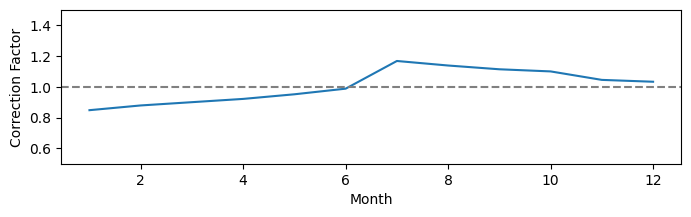

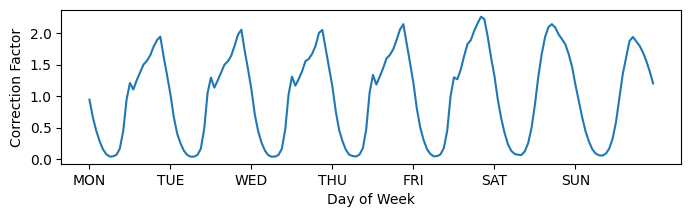

Hour  DOW
0     MON    0.944237
1     MON    0.666483
2     MON    0.453218
3     MON    0.286694
4     MON    0.156438
               ...   
19    SUN    1.798314
20    SUN    1.694887
21    SUN    1.557070
22    SUN    1.392544
23    SUN    1.202750
Length: 168, dtype: float64

In [8]:
raw = json.loads(metrics.redis.load_str("trafficmodel_params", "traffic-model-low"))
print(json.dumps(raw, indent=4))
from plantd_modeling import trafficmodel
model = trafficmodel.TrafficModel.deserialize_parameters(metrics.redis.load_str("trafficmodel_params", "traffic-model-low"))
plt.figure(figsize=(8, 2))
plt1 = model["corrections_monthly"].sort_index().plot()
plt1.set_ylim(.5, 1.5)
plt1.set_ylabel("Correction Factor")
# add dotted line at 1.0
plt1.axhline(y=1.0, color='grey', linestyle='--')
plt1.figure.savefig("corrections-monthly.png", bbox_inches='tight')
plt1.figure.set_size_inches(8,2)
plt.show()

hourly = model["corrections_hourly"]
day_map = {'MON': 0, 'TUE': 1, 'WED': 2, 'THU': 3, 'FRI': 4, 'SAT': 5, 'SUN': 6}

# Create a temporary column for sorting
hourly.index = pd.MultiIndex.from_tuples(
    [(day_map[dow], hour, dow) for dow, hour in hourly.index],
    names=['Sort', 'Hour', 'DOW']
)

# Sort by the temporary 'Sort' and 'Hour' levels
hourly.sort_index(inplace=True)

# Drop the 'Sort' level
hourly.index = hourly.index.droplevel('Sort')
plt.figure(figsize=(8, 2))
plt2 = hourly.plot(kind='line')

# Customize x-axis labels
plt.xticks(ticks=range(0, len(hourly), 24),  # Assuming 24 hours in each day
           labels=[dow for hour, dow in hourly.index[::24]])

plt.xlabel('Day of Week')
plt.ylabel('Correction Factor')
#plt.title('Hourly Corrections by Day of Week')

plt.show()
plt2.figure.savefig("corrections-hourly.png", bbox_inches='tight')

hourly


/var/folders/qr/gzr584k90hncw75zzl7nwgpm0000gp/T/ipykernel_37320/520788409.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(io.StringIO(raw), index_col=0, parse_dates=True)


                     Year  Month  Day  DOW  Hour  base_recs      monthly   
date                                                                       
2025-01-01 00:00:00  2025      1    1  WED     0       5000  4384.060831  \
2025-01-01 01:00:00  2025      1    1  WED     1       5000  4384.060831   
2025-01-01 02:00:00  2025      1    1  WED     2       5000  4384.060831   
2025-01-01 03:00:00  2025      1    1  WED     3       5000  4384.060831   
2025-01-01 04:00:00  2025      1    1  WED     4       5000  4384.060831   

                          hourly  
date                              
2025-01-01 00:00:00  4826.807507  
2025-01-01 01:00:00  3091.364538  
2025-01-01 02:00:00  1935.697187  
2025-01-01 03:00:00  1136.692450  
2025-01-01 04:00:00   591.474078  


/var/folders/qr/gzr584k90hncw75zzl7nwgpm0000gp/T/ipykernel_37320/520788409.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2 = pd.read_csv(io.StringIO(raw), index_col=0, parse_dates=True)


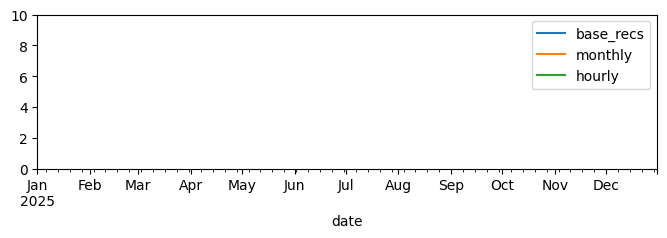

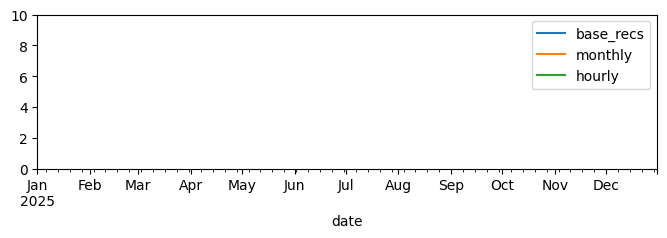

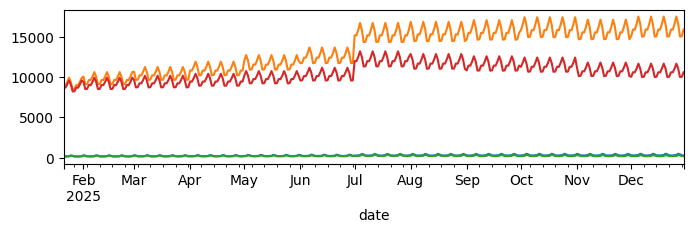

In [9]:

raw = metrics.redis.load_str("trafficmodel_predictions", f"traffic-model-low")
df = pd.read_csv(io.StringIO(raw), index_col=0, parse_dates=True)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
# make the following plot 8 inches wide and 2 inches tall
p1 = df[["base_recs","monthly","hourly"]].plot()
# make p1 6 inches wide and 2 inches tall
p1.set_ylim(0,10)
p1.figure.set_size_inches(8,2)

print(df.head())


raw = metrics.redis.load_str("trafficmodel_predictions", f"traffic-model-lowplus")
df2 = pd.read_csv(io.StringIO(raw), index_col=0, parse_dates=True)
df2["date"] = pd.to_datetime(df2["date"])
df2.set_index("date", inplace=True)
p2 = df2[["base_recs","monthly","hourly"]].plot()
p2.set_ylim(0,10)
p2.figure.set_size_inches(8,2)



# for df1 aggregate over day, finding max and min
# Resample and aggregate df to get daily min and max
daily_df = df.resample('D')['hourly'].agg(['min', 'max'])

# Resample and aggregate df2 to get daily min and max
daily_df2 = df2.resample('D')['hourly'].agg(['min', 'max'])

# Rename columns for clarity
daily_df.columns = ['nom min', 'nom max']
daily_df2.columns = ['low min', 'low max']

# Merge the two DataFrames
daily_combined = daily_df.join(daily_df2)
daily_combined = daily_combined.loc["2025-01-21":"2025-12-30"]
p3 = daily_combined.plot()
# omit the legend
p3.legend().set_visible(False)
p3.figure.set_size_inches(8,2)
plt.savefig("projections-minmax.png", bbox_inches='tight')





In [10]:
for experiment in experiments:
    print(experiment)
    inf = json.loads(metrics.redis.load_str("experiment_cost", experiment))
    total_cost = sum([inf[x]["total_cost"] for x in inf])
    direct_cost = sum([inf[x]["direct_cost"] for x in inf])
    shared_cost = sum([inf[x]["shared_cost"] for x in inf])
    print(experiment, total_cost, direct_cost, shared_cost)


ubi-chris-test.ubi-chris-test-bad-triangle-3
ubi-chris-test.ubi-chris-test-bad-triangle-3 0.0028099977359593597 0.0024396273655889894 0.00037037037037037035
ubi-chris-test.ubi-chris-test-good-triangle-3
ubi-chris-test.ubi-chris-test-good-triangle-3 0.007615543826082263 0.007245173455711893 0.0003703703703703705
ubi-chris-test.ubi-chris-test-fixed-triangle-3
ubi-chris-test.ubi-chris-test-fixed-triangle-3 0.0027561994043762807 0.00238582903400591 0.00037037037037037035


In [11]:
models = {}
models["blocking-write"] = json.loads(metrics.redis.load_str("twinmodel", "ubi-chris-test.chris-model-bad-tri"))
models["non-blocking-write"] = json.loads(metrics.redis.load_str("twinmodel", "ubi-chris-test.chris-model-good-tri"))
models["cpu-limited"] = json.loads(metrics.redis.load_str("twinmodel", "ubi-chris-test.chris-model-fixed-tri"))


# make latex table like above, with columns model_type, maxrate_rps, per_vm_hourcost, avg_latency_s, and policy
twinmodel_summary = ("""
\\begin{table}[]
\\begin{tabular}{llllll}
""")
twinmodel_summary += (" & ".join(["Model", "max rec/s", "\$/hr", "avg latency", "policy"]))
twinmodel_summary += "\\\\ \\hline\n"
for modelname in models:
    model = models[modelname]
    twinmodel_summary += (" & ".join([modelname, str(round(model["maxrate_rps"],2)), str(round(100*model["per_vm_hourcost"],2)), str(round(model["avg_latency_s"],2)), str(model["policy"])]))
    twinmodel_summary += ("\\\\\n")
twinmodel_summary += ("\\hline\n")
twinmodel_summary += ("""\\end{tabular}
\\caption{Parameters of three twin models, derived from the three experiments.}
\\label{tab:twinmodel-summary}
\\end{table}
""")

print(twinmodel_summary)
with open("twinmodel-summary.tex", "w") as f:
    f.write(twinmodel_summary)



\begin{table}[]
\begin{tabular}{llllll}
Model & max rec/s & \$/hr & avg latency & policy\\ \hline
blocking-write & 1.95 & 0.82 & 0.15 & fifo\\
non-blocking-write & 6.15 & 7.03 & 0.06 & fifo\\
cpu-limited & 0.66 & 0.27 & 0.29 & fifo\\
\hline
\end{tabular}
\caption{Parameters of three twin models, derived from the three experiments.}
\label{tab:twinmodel-summary}
\end{table}

